In [1]:
from qreduce.cs_vqe import cs_vqe
from qreduce.utils import *
from itertools import combinations
import json
import numpy as np

In [2]:
with open('data/model_data.json', 'r') as infile:
        mol_data = json.load(infile)
mol_data.keys()

dict_keys(['H2O_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'HeH+_6-311G_SINGLET', 'BeH+_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'NH_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'CH2_STO-3G_TRIPLET', 'C_STO-3G_TRIPLET'])

In [22]:
mol=mol_data['C_STO-3G_TRIPLET']
ham=mol['ham']
ansatz = mol['ansatze']['uccsd']
n_q=mol['num_qubits']
set_nc = mol['terms_noncon']
cs_vqe_mol = cs_vqe(ham, noncontextual_set = set_nc, single_pauli='Z')

In [23]:
print("Generators:", cs_vqe_mol.generators)
print("Clique reps:", cs_vqe_mol.cliquereps)
#match=mol['X_index']==cs_vqe_mol.anti_clique_qubit
#print('Anti-clique qubit match?', match, '\n')

print("G assignment:", cs_vqe_mol.nu)#, ' | original:', np.array(list(mol['G'].values()), dtype=int))
print("r vector:", cs_vqe_mol.r)
print("Noncon nrg:", cs_vqe_mol.ngs_energy)
print('NGS matches original?', abs(cs_vqe_mol.ngs_energy-mol['noncon'])<1e-13, '\n')

Generators: ['ZZIZI', 'ZZZIZ', 'ZIZIZ', 'ZZIIZ', 'ZZZII']
Clique reps: ['IIIXZ', 'ZZIZI']
G assignment: [ 1 -1 -1  1  1]
r vector: [-4.65559701e-08  1.00000000e+00]
Noncon nrg: -37.19839256373157
NGS matches original? True 



In [24]:
num_sim_q = mol['chem_acc_num_q']
exact, gs = exact_gs_energy(cs_vqe_mol.hamiltonian)
print('Exact energy:',exact)
print('Noncon error:', cs_vqe_mol.ngs_energy-exact)
print(f'Target_error for {num_sim_q} qubits:', exact_gs_energy(mol['ham_reduced'][num_sim_q])[0]-exact)

Exact energy: -37.21873355063646
Noncon error: 0.020340986904884062
Target_error for 2 qubits: 0.00011593095587159041


In [25]:
optimal_error = {}
for num_sim_q in range(1, cs_vqe_mol.num_qubits):
    cs_vqe_errors = []
    for order in combinations(range(len(cs_vqe_mol.generators)), cs_vqe_mol.num_qubits - num_sim_q):
        order = list(order)
        ham_cs = cs_vqe_mol.contextual_subspace_hamiltonian(order)
        cs_energy, cs_vector = exact_gs_energy(ham_cs)
        cs_vqe_errors.append((cs_energy-exact, order))
    cs_vqe_errors = sorted(cs_vqe_errors, key=lambda x:x[0])
    optimal_error[num_sim_q] = cs_vqe_errors[0]
    
optimal_error

{1: (0.020340986904891167, [1, 2, 3, 4]),
 2: (0.00011593082034977442, [0, 1, 3]),
 3: (8.187161783723695e-05, [1, 3]),
 4: (4.117318268725967e-05, [1])}

In [26]:
order  = [0,1]
num_sim_q = cs_vqe_mol.num_qubits - len(order)
ham_cs = cs_vqe_mol.contextual_subspace_hamiltonian(stabilizer_indices=order)
anz_cs = cs_vqe_mol._contextual_subspace_projection(operator=ansatz, stabilizer_indices=order)

In [27]:
print(ham_cs)

{'III': -30.930444308644365, 'ZZI': 0.268593428408034, 'ZII': 0.327186564075417, 'IZZ': -5.288731282819684, 'ZIZ': 0.29748676486961, 'IIZ': 0.224153132897281, 'IZI': 0.128244761278534, 'ZZZ': -0.387925448889483, 'IXZ': -8.44261e-10, 'ZXI': -8.44261e-10, 'IYY': -0.032711314378203, 'ZXX': 0.032711314378203, 'XYY': 0.032711315055016, 'YYX': -0.032711315055016, 'IZX': -1.522907e-09, 'IIX': 1.522907e-09, 'IXX': -0.032711314716609, 'ZYY': 0.032711314716609, 'XXX': -0.032711314716609, 'YXY': -0.032711314716609}


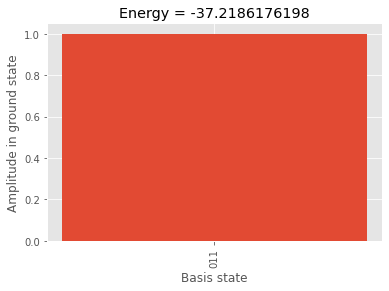

In [28]:
plot_ground_state_amplitudes(operator=ham_cs, num_qubits=num_sim_q)

In [29]:
stabilizer_map = cs_vqe_mol.noncontextual_ground_state(stabilizer_indices=order)

ZIZIZ {'rotations': [('IYIII', 1.5707963267948966, True), ('IYZII', 1.5707963267948966, True)], 'single_pauli_index': 1, 'single_pauli': 'IZIII', 'eigenvalue': 1}
ZZIIZ {'rotations': [('IIIYI', 1.5707963267948966, True), ('ZIIYZ', 1.5707963267948966, True)], 'single_pauli_index': 3, 'single_pauli': 'IIIZI', 'eigenvalue': 1}
ZZZII {'rotations': [('IIIIY', 1.5707963267948966, True), ('IIZIY', 1.5707963267948966, True)], 'single_pauli_index': 4, 'single_pauli': 'IIIIZ', 'eigenvalue': -1}


In [30]:
anz_cs

{}